가우스 혼합 모델(Gaussian Mixture Model)
===============

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

k-평균 군집화의 문제점과 해결 방안
-------------

**k-평균 군집화의 문제점**

1. 군집 모양이 원 모양만 가능하여 유연성이 떨어진다  
2. 확률적 군집 할당이 빈약하다  


**해결 방안**

1. 각 점을 모든 군집의 중심까지의 거리를 비교함으로써 군집 할당의 불확실성을 측정하는 방법
2. 원형이 아닌 군집을 설명하기 위해 원형이 아닌 타원형을 군집의 경계로 허용하는 방법  

E-M 단계 일반화하기 : 가우스 혼합 모델
    ----------------------

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4, 
                      cluster_std = 0.60, random_state = 0)
X = X[:, ::-1]

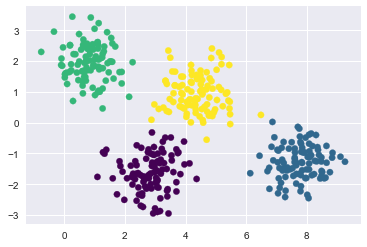

In [4]:
from sklearn.mixture import GMM
gmm = GMM(n_components = 4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis')

GMM은 내부적으로 확률 모델을 포함하고 있기 때문에, 확률적으로 군집을 할당하는 것도 가능하다  
scikitlearn에서는 이 작업에 predict_proba 메서드를 사용하면 된다. 이 메서드는 특정 군집에 속한  
모든 점들의 확률을 측정한 크기가 [n_samples, n_clusters]인 행렬로 반환한다  

In [7]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.475 0.    0.525]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


이 불확실성을 예를 들어 각 점의 크기를, 그 예측의 확실성에 비례하게 만들어서 표현할 수 있다 

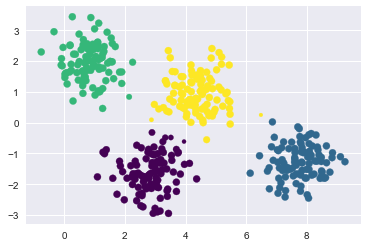

In [8]:
size = 50 * probs.max(1) ** 2  # 제곱으로 차이 강조
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis', s = size)

내부적으로 가우스 혼합 모델은 k-평균과 매우 비슷하다. 이 모델 역시 질적으로 다음 작업을 수행하는  
기댓값-최대화 방식을 사용한다  

1. 위치와 모양을 예측한다
2. 수렴될 때까지 다음 단계를 반복한다  
   E-단계 : 각 점에 대해 각 군집의 일원일 가능성을 인코딩한 가중치를 구한다  
   M-단계 : 모든 데이터 점을 기반으로 가중치를 사용해 각 군집의 위치, 정규화, 모양을 업데이트한다.  

GMM 결과를 기반으로 한 타원형을 그려서 GMM 군집의 위치와 모양을 시각화할 함수이다

In [12]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax = None, **kwargs):
    """주어진 위치와 공분산으로 타원 그리기"""
    ax = ax or plt.gca()
    # 공분산을 주축으로 전환
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # 타원 그리기
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig ** width, nsig * height,
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label = True, ax = None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', zorder = 2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s = 40, zorder = 2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)

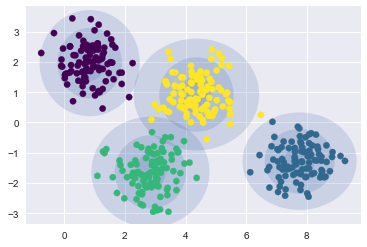

In [13]:
gmm = GMM(n_components = 4, random_state = 42)
plot_gmm(gmm, X)

마찬가지로 GMM 방식을 사용해 펼쳐진 모양의 데이터세트를 적합할 수 있다.  
이 모델은 완전 공분산을 허용해 모델이 매우 길쭉하게 쭉 뻗은 군집을 적합시킨다.  

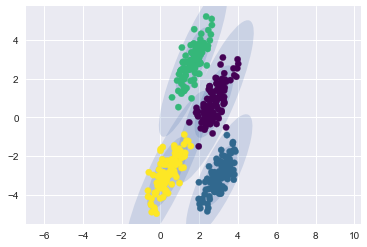

In [14]:
rng = np.random.RandomState(42)
X_stretched = np.dot(X, rng.randn(2, 2))
gmm = GMM(n_components = 4, covariance_type = 'full', random_state = 42)
plot_gmm(gmm, X_stretched)

이전 적합을 자세히 들여다 보면 각각에 covariance_type 옵션을 다르게 설정했음을 볼 수 있다  
이 초모수는 각 군집 모양의 자유도를 제어하기 때문에 주어진 문제에 대해 이 초모수를 신중하게  
설정해야 한다  
1. `covariance_type = 'diag'` : 기본값이며, 이것을 사용하면 각 차원에 따라 군집의 크기를   
    독립적으로 설정할 수 있고 결과로 얻는 타원은 축에 따라 정렬된다  
  
2. `covariance_type = 'spherical'` : 군집의 모양을 모든 차원이 동일하도록 제한한다. 결과로  
    얻은 군집은 k-평균과 완전히 똑같지는 않지만 비슷한 특징을 지니게 된다  
      
3. `covariance_type = 'full'` : 각 군집이 임의의 방향을 가지는 타원형으로 모델링된다.  
    더 복잡하고 계산 비용이 높은 모델에 적합하다  

밀도 추정에 GMM 사용하기
-------------------

GMM은 종종 군집화 알고리즘으로 분류되지만, 근본적으로는 밀도 추정 알고리즘이다.  
말하자면 어떤 데이터에 GMM을 적합한 결과는 기술적으로 군집화 모델이 아니라   
데이터의 분포를 나타내는 생성 확률 모델이다  

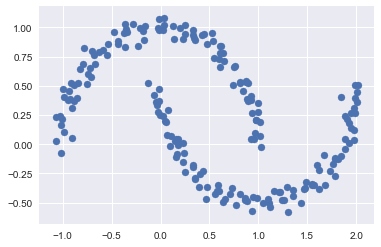

In [17]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise = .05, random_state = 0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

GMM을 군집화 모델로 이 데이터에 적합시키려 하면 결과는 그다지 쓸모가 없을 것이다  

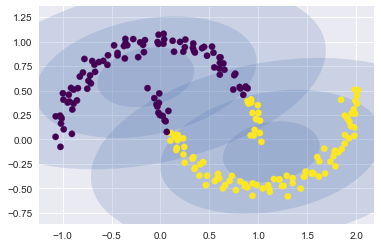

In [18]:
gmm2 = GMM(n_components = 2, covariance_type = 'full', random_state = 0)
plot_gmm(gmm2, Xmoon)

대신 훨씬 더 많은 성분을 사용하고, 군집 레이블을 무시하면 입력 데이터에 훨씬  
근접한 적합을 구하게 된다  

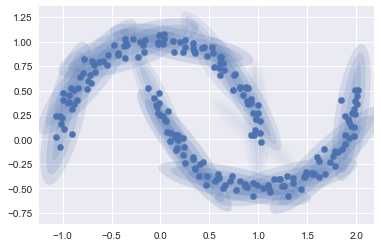

In [20]:
gmm16 = GMM(n_components = 16, covariance_type = 'full', random_state = 0)
plot_gmm(gmm16, Xmoon, label = False)

여기서 16개의 가우스 혼합은 분리된 데이터 군집을 발견하는 것이 아니라 입력 데이터의 전반적인  
분포를 모델링하는 데 이용된다.  이것이 바로 분포의 생성 모델이며, GMM이 입력 데이터와 비슷하게  
분포된 임의의 새로운 데이터를 생성할 수 있는 레시피를 제공한다는 뜻이다. 예를 들어 다음은 원본  
데이터에 적합시킨 GMM으로부터 얻어낸 400개의 새로운 데이터다  

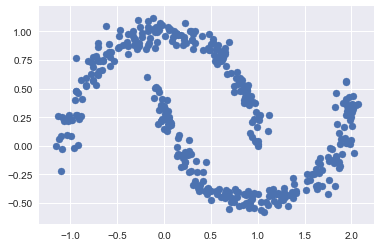

In [21]:
Xnew = gmm16.sample(400, random_state = 42)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

**얼마나 많은 성분을 사용할 것인가?**  
GMM이 일종의 생성 모델이라는 사실은 주어진 데이터세트에 대해 최적의 성분 개수를 결정하는  
자연스러운 수단을 제공한다. 과적합을 바로 잡는 방법 중에는 아카이케 정보 기준(AIC)이나  
베이즈 정보 기준(BIC)과 같은 분석 기준을 사용해 모델 우도를 조정하는 것이다.  

Text(0.5,0,'n_components')

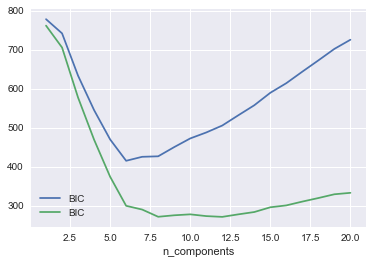

In [22]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type = 'full', random_state = 0).fit(Xmoon)
         for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label = 'BIC')
plt.legend(loc = 'best')
plt.xlabel('n_components')

최적의 군집 수는 AIC와 BIC를 최소화하는 값으로, 사용하고자 하는 근사법인 무엇이냐에 따라 달라진다  
AIC를 보면 16성분은 너무 많고, 8~12 성분 정도가 적당할 것이다. 이러한 종류의 문제에서는 일반적으로  
그렇듯이 BIC가 더 간단한 모델을 추천한다.  
GMM을 주로 밀도 추정기로 여기고 간단한 데이터세트 내에서 보장될 때만 군집화 알고리즘으로 사용하는  
것이 좋을 것이다.  

예제 : 새로운 데이터를 생성하는 GMM
    ------------------

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

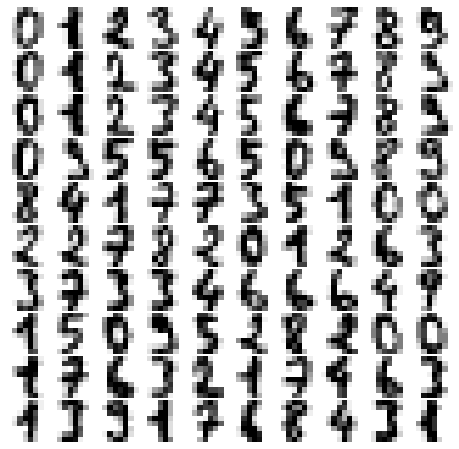

In [25]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize = (8, 8),
                          subplot_kw = dict(xticks = [], yticks = []))
    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap = 'binary')
        im.set_clim(0, 16)

plot_digits(digits.data)

GMM은 이러한 고차원 공간에서 수렴이 어려울 수 있으므로 먼저 데이터에 가역 차원 축소  
알고리즘을 적용할 것이다. 여기에서는 간단한 PCA를 사용하고 사영된 데이터에서 분산의  
99%를 보존하게 할 것이다  

In [26]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten = True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

그 결과 정보 유실은 거의 없이 차원은 1/3 수준으로 축소된 41차원 데이터를 얻었다. 이 사영된  
데이터를 가지고 AIC를 사용해 예제에 쓸 GMM 성분 개수의 기준을 구해 보자  

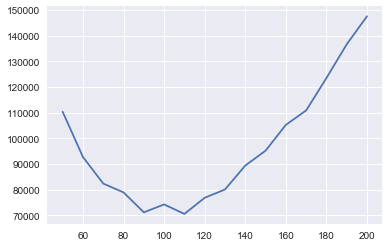

In [28]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type = 'full', random_state = 0)
         for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

약 110개의 성분이 AIC를 최소화하는 것으로 밝혀졌다. 이 모델을 사용해 데이터를 적합시키고  
이 모델이 수렵하는지 확인해보자  

In [29]:
gmm = GMM(110, covariance_type = 'full', random_state = 0)
gmm.fit(data)
print(gmm.converged_)

True


이제 생성 모델로 GMM을 사용해 41차원 사영된 공간에서 100개의 새로운 점의 표본을 얻을 수 있다  

In [30]:
data_new = gmm.sample(100, random_state = 0)
data_new.shape

(100, 41)

마지막으로 새로운 숫자를 구성하기 위해 PCA 객체의 가역 변환을 사용한다  

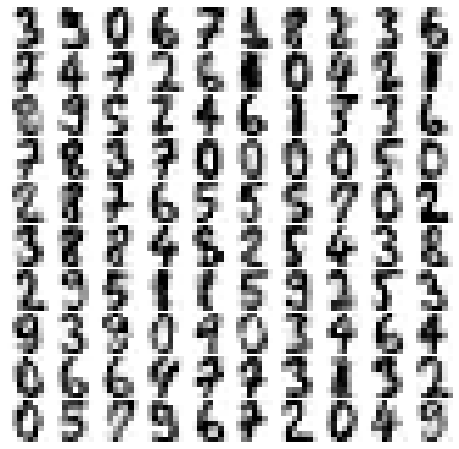

In [31]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)